This notebook plots output from the GMM models.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from scipy import stats
from tqdm.notebook import tqdm

sns.set_theme(style = 'dark')

# Load Data

### Original data

In [5]:
DATA_DIR = '../../data/combined_macro_micro_wind_data.csv'

data = pd.read_csv(DATA_DIR)

# isolate U and V columns
u_cols = [f'u{i}' for i in np.arange(20, 255, 5)]
v_cols = [f'v{i}' for i in np.arange(20, 255, 5)]
macro_cols = ['macro_ws', 'macro_wd']

# big dataset
data_full = data[u_cols + v_cols + macro_cols]

# remove the empty columns and rows
# data.dropna(axis=1, how='all', inplace=True)
data_full.dropna(inplace=True)
print(data_full.shape)

data_u = data_full[u_cols].copy()
data_v = data_full[v_cols].copy()

# average over altitude for visualization
data_uv = np.zeros(shape=(data_u.shape[0], 2))
data_uv[:, 0] = data_u.values.mean(axis=1)
data_uv[:, 1] = data_v.values.mean(axis=1)

# define the indices for the u and v components
u_idxs = np.arange(47)
v_idxs = np.arange(47, 94)

# include macro data
macro_cols = [col for col in data_full.columns.values if 'macro' in col]
macro_cols_w = ['macro_ws', 'macro_wd']

data_macro = data_full[macro_cols].copy()

(6542, 96)


C:\Users\mcstanl1\AppData\Local\Temp\1\ipykernel_11204\1227225927.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_full.dropna(inplace=True)


### Model-sampled data

In [3]:
# Load data sampled from lower dimensional PCA space
with open('../../data/data_sampled_reconstruct.npy', 'rb') as f:
    data_sampled_reconstruct = np.load(file=f)

# Diagnostic plots of sampling capability

### Unconditional

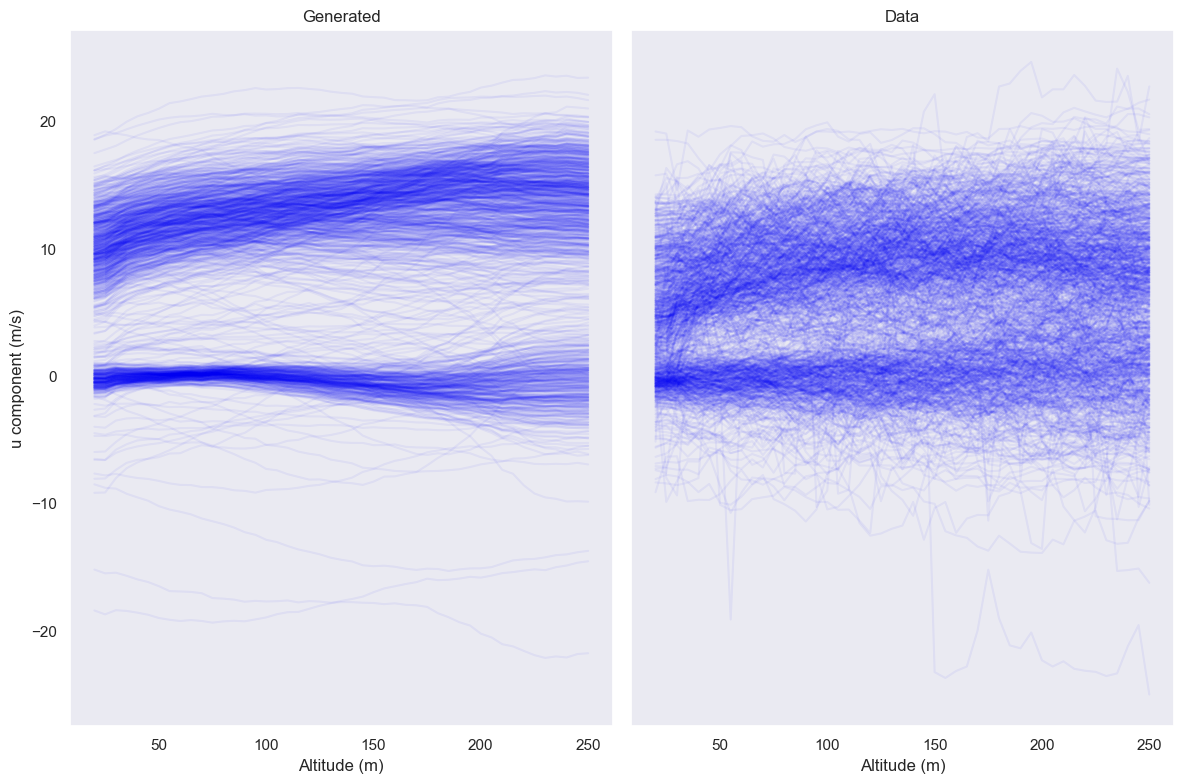

In [6]:
# plot realizations across the altitude levels
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 8), sharex=True, sharey=True)

# generated
for i in range(1000):
    ax[0].plot(np.arange(20, 255, step=5), data_sampled_reconstruct[i, u_idxs], color='blue', alpha=0.05)
ax[0].set_xlabel('Altitude (m)')
ax[0].set_ylabel('u component (m/s)')
ax[0].set_title('Generated')

# original
rand_idx = np.random.choice(np.arange(data_full.shape[0]), size=data_full.shape[0], replace=False)
for i in range(1000):
    ax[1].plot(np.arange(20, 255, step=5), data_full.iloc[rand_idx[i], u_idxs], color='blue', alpha=0.05)
ax[1].set_xlabel('Altitude (m)')
ax[1].set_title('Data')

plt.tight_layout()
plt.show()

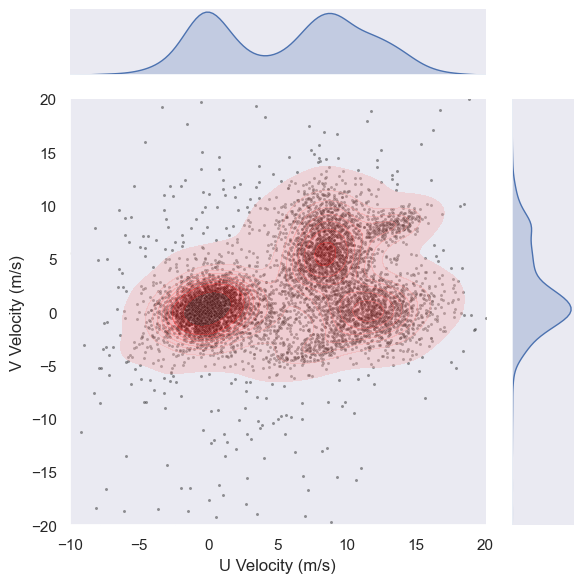

In [7]:
# aggregate the above into average u and v
sampled_u_reconstruct = data_sampled_reconstruct[:, u_idxs].mean(axis=1)
sampled_v_reconstruct = data_sampled_reconstruct[:, v_idxs].mean(axis=1)

g = sns.JointGrid(
    xlim=(-10.0, 20.0), ylim=(-20.0, 20.0)
)
sns.scatterplot(
    x=sampled_u_reconstruct,
    y=sampled_v_reconstruct,
    color='black',
    s=5,
    alpha=0.4,
    ax=g.ax_joint)
sns.kdeplot(
    x=sampled_u_reconstruct,
    y=sampled_v_reconstruct,
    color='red', fill=True, alpha=0.4, ax=g.ax_joint
)
sns.kdeplot(x=sampled_u_reconstruct, fill=True, ax=g.ax_marg_x)
sns.kdeplot(y=sampled_v_reconstruct, fill=True, ax=g.ax_marg_y)
g.set_axis_labels('U Velocity (m/s)', 'V Velocity (m/s)')
g.figure.tight_layout()

### Conditional

In [8]:
# load in wind speed data
with open('../../data/data_sampled_wind_speed.npy', 'rb') as f:
    data_sampled_ws = np.load(file=f)

In [12]:
# compute speed of sampled values
sampled_macro_ws = np.sqrt(data_sampled_reconstruct[:, -2] ** 2 + data_sampled_reconstruct[:, -1] ** 2)

# make a numpy array of true windspeeds
ws_cols = [col for col in data.columns.values if 'ws' in col][:47]
data_ws = data[ws_cols].values.copy()
print(data_ws.shape)

# create index categories
category_names = ['(0, 2.23)', '[2.23, 5.36)', '[5.36, 8.05)', '[8.05, 15.65)']
category_idxs_sampled = {
    0: sampled_macro_ws < 2.23,
    1: (sampled_macro_ws >= 2.23) & (sampled_macro_ws < 5.36),
    2: (sampled_macro_ws >= 5.36) & (sampled_macro_ws < 8.05),
    3: (sampled_macro_ws > 8.05) & (sampled_macro_ws < 15.65)
}

# create windspeed mask for true data
category_idxs_true = {
    0: data.macro_ws < 2.23,
    1: (data.macro_ws >= 2.23) & (data.macro_ws < 5.36),
    2: (data.macro_ws >= 5.36) & (data.macro_ws < 8.05),
    3: (data.macro_ws > 8.05) & (data.macro_ws < 15.65)
}

(7200, 47)


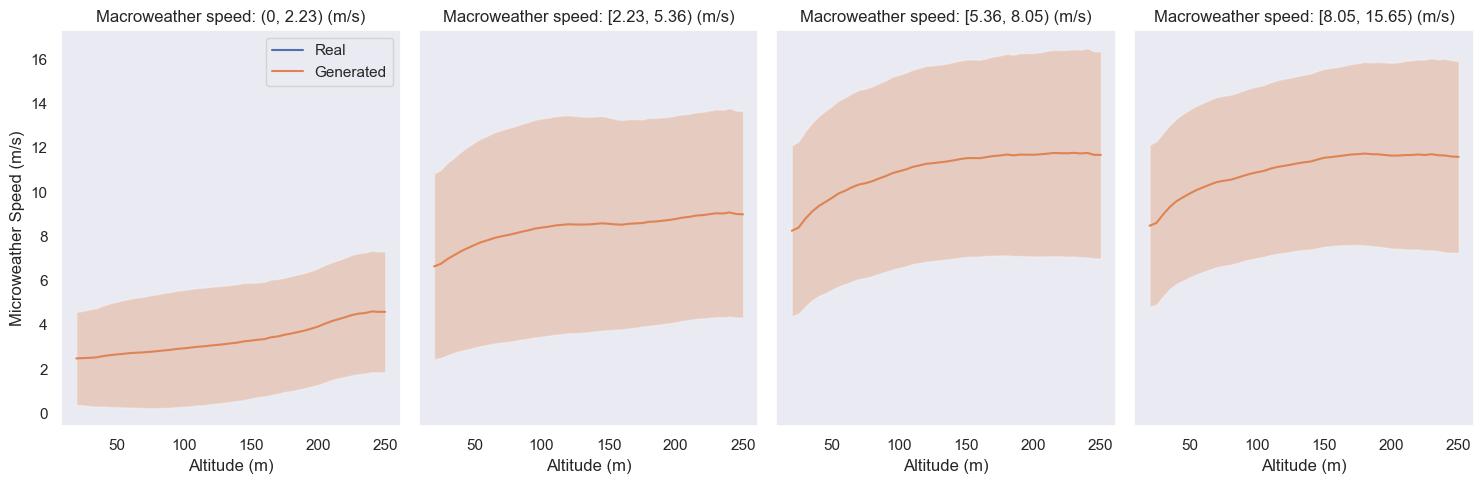

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 5), sharex=True, sharey=True)
QUANTILES = [5, 50, 95]

for i in range(4):

    # plot TRUE
    means_true_i = np.mean(data_ws[category_idxs_true[i]], axis=0)
    std_true_i = np.std(data_ws[category_idxs_true[i]], axis=0)
    ax[i].fill_between(
        x=np.arange(20, 255, step=5), y1=means_true_i - std_true_i, y2=means_true_i + std_true_i,
        alpha=0.3
    )
    ax[i].plot(np.arange(20, 255, step=5), means_true_i, label='Real')
    
    # plot GENERATED
    means_gen_i = np.mean(data_sampled_ws[category_idxs_sampled[i]], axis=0)
    std_gen_i = np.std(data_sampled_ws[category_idxs_sampled[i]], axis=0)
    ax[i].fill_between(
        x=np.arange(20, 255, step=5), y1=means_gen_i - std_gen_i, y2=means_gen_i + std_gen_i,
        alpha=0.3
    )
    ax[i].plot(np.arange(20, 255, step=5), means_gen_i, label='Generated')
    
    ax[i].set_xlabel('Altitude (m)')
    if i == 0:
        ax[i].set_ylabel('Microweather Speed (m/s)')
        ax[i].legend()
    ax[i].set_title(f'Macroweather speed: {category_names[i]} (m/s)')

plt.tight_layout()
plt.show()